CT2 TRAINING:
- 1JHN DONE (-1.55)
- 2JHN DONE (-2.65)
- 3JHN DONE (-2.96)
- 2JHH DONE (-2.66)
- 3JHH DONE (-2.93)
- 1JHC

CT2 NF TRAINING:
- 1JHN DONE (-1.55)
- 1JHC DONE (-1.38) (~100 epoch left)

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pickle, numba, torch, tqdm, random, utils, os, gc, time

from collections import OrderedDict, defaultdict
from copy import deepcopy

from rdkit.Chem.AtomPairs.Utils import NumPiElectrons
from rdkit.Chem.rdMolTransforms import GetAngleRad, GetBondLength
from rdkit.Chem.rdchem import Atom, Bond
from rdkit.Chem.AtomPairs.Pairs import rdMolDescriptors as rdmd
from rdkit import Chem, RDConfig
from rdkit.Chem import ChemicalFeatures

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Dropout, SELU
from torch_geometric.data import Data
from torch_geometric.nn import NNConv, Set2Set, GATConv
from torch_geometric.data import DataLoader


%config InlineBackend.figure_format ='retina'

In [2]:
train = pd.read_csv('train.csv')
structures = pd.read_csv("structures.csv")

In [3]:
gratio = pd.DataFrame({"atom":["H","C","N","O","F"],
                       "Gratio": [42.576,10.705,-4.316,-5.772,40.060],
                       "Eneg": [2.2,2.55,3.04,3.44,3.98],
                       "radius":[110,170,155,152,147],
                       "atomic_num":[1,6,7,8,9],
                       "numv":[1,4,5,6,7]})
structures = structures.merge(gratio,how='left',on='atom')

In [4]:
train = train.groupby('type').get_group('1JHC')

In [5]:
t2 = pd.read_csv('train.csv')
t2 = t2[t2['molecule_name'].isin(train['molecule_name'])]
t2.drop(['id','type','scalar_coupling_constant'],axis=1,inplace=True)

In [6]:
from collections import defaultdict
molcouples = defaultdict(list)
cpv = t2.values.tolist()
for c in tqdm.tqdm_notebook(cpv):
    molcouples[c[0]].append((c[1],c[2]))

In [7]:
train.drop('type',axis=1,inplace=True)

In [8]:
train = utils.map_atom_info(train,0,structures)
train = utils.map_atom_info(train,1,structures)

In [9]:
with open('rdkitmolecules.p', 'rb') as fp:
    d = pickle.load(fp)

In [10]:
tf = train.groupby('molecule_name')

In [11]:
groups = list(tf.groups.keys())

In [12]:
len(groups)

84747

In [13]:
with open("trainmols1JHC.txt", "rb") as fp:   # Unpickling
    trainmols = pickle.load(fp)    
with open("valmols1JHC.txt", "rb") as fp:   # Unpickling
    valmols = pickle.load(fp)    

In [14]:
len(trainmols)+len(valmols)

84747

In [15]:
len(trainmols)

70000

In [16]:
len(valmols)

14747

In [17]:
tc = []
vc = [] 
for i in tqdm.tqdm_notebook(trainmols):
    g = tf.get_group(i)
    tc.append(g)
for i in tqdm.tqdm_notebook(valmols):
    g = tf.get_group(i)
    vc.append(g)

In [18]:
train = pd.concat(tc)

In [19]:
print(len(train),train['molecule_name'].nunique())

586078 70000


In [20]:
val = pd.concat(vc)

In [21]:
print(len(val),val['molecule_name'].nunique())

123338 14747


In [22]:
molnames = list(train['molecule_name'].unique())
mols = OrderedDict()

for name in molnames:
    mols[name] = d[name]
    
struct =  structures[structures['molecule_name'].isin(molnames)]
g = struct.groupby('molecule_name')

struct.head()

,molecule_name,atom_index,atom,x,y,z,Gratio,Eneg,radius,atomic_num,numv
16,dsgdb9nsd_000005,0,C,-0.013324,1.132466,0.008276,10.705,2.55,170,6,4
17,dsgdb9nsd_000005,1,N,0.002311,-0.019159,0.001929,-4.316,3.04,155,7,5
18,dsgdb9nsd_000005,2,H,-0.027803,2.198949,0.014154,42.576,2.20,110,1,1
19,dsgdb9nsd_000007,0,C,-0.018704,1.525582,0.010433,10.705,2.55,170,6,4
20,dsgdb9nsd_000007,1,C,0.002104,-0.003882,0.001999,10.705,2.55,170,6,4


In [23]:
struct['molecule_name'].nunique()

70000

In [24]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [25]:
atfn = {'Acceptor':0,
         'Aromatic':1,
         'Donor':2,
         'Hydrophobe':3,
         'LumpedHydrophobe':4,
         'NegIonizable':5,
         'PosIonizable':6,
         'ZnBinder':7}

In [26]:
#ADD DISTANCE TO TARGET FEATURE
def getAtomNodeFeats(molname, mols, data):
    symbol, x, y, z, gr,eneg,radius,atomnum,nv = 2,3,4,5,6,7,8,9,10
    mol = mols[molname]
    feats = factory.GetFeaturesForMol(mol)
    atfdict = defaultdict(list)
    for i in range(len(feats)):
        fam = feats[i].GetFamily()
        dl = feats[i].GetAtomIds()
        for aid in dl:
            atfdict[aid].append(fam)
    
    l = len(data)
    nodef = []
    
    eems = rdmd.CalcEEMcharges(mol)
    spfd = {'S':0,'SP':0.5,'SP2':1/3,'SP3':1/4}
    
    for i in range(l):
        d = data[i]
        atom = mol.GetAtomWithIdx(i)
        ahyb =  str(atom.GetHybridization())
        sym = d[symbol]
        hf = 'NONE'
        if i in atfdict:
            hf = atfdict[i]
        ff = [sym=='H',sym=='C',sym=='N',sym=='O',sym=='F',d[atomnum],(int)(atom.IsInRing() == True),
              ahyb=='S',ahyb=='SP', ahyb=='SP2', ahyb=='SP3',d[x],d[y],d[z],eems[i],spfd[ahyb],
              d[radius],d[eneg],d[gr],NumPiElectrons(atom),0,0]
        ff += ([0]*135)#         
        newf = [0,0,0,0,0,0,0,0, 0,0,0,0, 0,0,0,0,0,0,0,0,0,0]
        newf[-11] = d[nv]
        if hf != 'NONE':
            for t in hf:
                newf[atfn[t]] = 1
            
        ff += newf
        nodef.append(ff)
    
    lm = molcouples[molname]
    for i,(a0,a1) in enumerate(lm):
        nodef[a0][22+i] = 1
        nodef[a1][22+i] = 1
    return nodef

In [27]:
@numba.jit(nopython=True)
def getAngle(x0,y0,z0,x1,y1,z1):
    mag_x0 = np.sqrt(x0**2 + y0**2 + z0**2)
    mag_x1 = np.sqrt(x1**2 + y1**2 + z1**2)
    dotp = (x0*x1) + (y0* y1) + (z0*z1)
    c = dotp/(mag_x0*mag_x1)
    if c < -1:
        c = -1
    elif c > 1:
        c = 1
    theta = np.arccos(c)
    return theta, np.cos(theta), np.sin(theta)

In [28]:
def getBondEdgeFeats(molname, mols, data):
    x, y, z = 3,4,5
    mol = mols[molname]
    bonds = mol.GetBonds()
    src,dst = [],[]
    bondf = []
    aed = defaultdict(list)
    
    btd = {'AROMATIC':0,'SINGLE':1,'DOUBLE':2, 'TRIPLE':3}
    #make bidirectional
    for bond in bonds:
        id0,id1 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        
        src.append(id0)
        dst.append(id1)
        src.append(id1)
        dst.append(id0)
        
        aed[id0].append(id1)
        aed[id1].append(id0)
        
        t0,t1 = data[id0],data[id1]
        x0,y0,z0,x1,y1,z1 = t0[x],t0[y],t0[z],t1[x],t1[y],t1[z]   
                
        d = GetBondLength(mol.GetConformer(),id0,id1)
        a,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
        isconj = (int)(bond.GetIsConjugated() == True)
        btype =  str(bond.GetBondType())
        bt = [0,0,0,0]
        bt[btd[btype]] = 1
        #angle t0, cos t0, sin t0, angle t1, cos t1, sin t1, angle tv, cos tv, sin tv
        ff = [d,a,cos,sin,isconj] + bt + [0,0,0,0,0,0,0,0,0]
        bondf.append(ff)
        bondf.append(ff)
        #[blen,angle,cos,sin,isconj,bt,bt,bt,bt]
    edge_index = []
    edge_index.append(src)
    edge_index.append(dst)
    #tonorm: 0,1,2,3,4
    return bondf, edge_index, aed    

In [29]:
mnames = list(mols.keys())

datadir = {}
for name in tqdm.tqdm_notebook(mnames):
    a = g.get_group(name)
    nodef = getAtomNodeFeats(name,mols,a.values.tolist())
    bondf, edgeidx, aed = getBondEdgeFeats(name,mols,a.values.tolist())
    datadir[name] = [nodef, bondf, edgeidx, aed]

In [30]:
train= train.drop(['atom_0', 'x_0', 'y_0', 'z_0', 'Gratio_x',
            'Eneg_x', 'radius_x', 'atomic_num_x', 'atom_1', 'x_1', 'y_1', 'z_1',
            'Gratio_y', 'Eneg_y', 'radius_y', 'atomic_num_y'],axis=1)

In [31]:
t = train.values.tolist()

In [32]:
@numba.jit(nopython=True)
def getDist(x0,y0,z0,x1,y1,z1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2 + (z0-z1)**2)

In [33]:
olds = np.seterr(all='raise')

In [34]:
train = train.drop(['numv_x','numv_y'],axis=1)

In [35]:
trainlist = []
l = len(t)
for dp in tqdm.tqdm_notebook(t):
    name, id0, id1, y = dp[1], dp[2], dp[3], dp[4]
    n,b,e,aed = datadir[name]
    nodef,bondf,edgeidx = np.array(n), np.array(b), np.array(e)
    nodef,bondf,edgeidx = nodef.tolist(),bondf.tolist(),edgeidx.tolist()
    
    nodef[id0][-1] = 1
    nodef[id1][-1] = 1
    
    nid0 = nodef[id0]
    nid1 = nodef[id1]
    x0,y0,z0 = nid0[11],nid0[12],nid0[13]
    x1,y1,z1 = nid1[11],nid1[12],nid1[13]
    xf,yf,zf = x0-x1,y0-y1,z0-z1
    
    ll = len(nodef)
    ai0 = aed[id0]
    ai1 = aed[id1]
    for i in range(ll):
        if i not in ai0 and i != id0:
            temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            tnf = nodef[i]
            xi,yi,zi = tnf[11],tnf[12],tnf[13]
            temp[0] = getDist(xi,yi,zi,x0,y0,z0)
            theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
            temp[1] = theta
            temp[2] = cos
            temp[3] = sin
            
            bondf.append(temp)
            bondf.append(temp)
            
            edgeidx[0].append(i)
            edgeidx[1].append(id0)
            
            edgeidx[0].append(id0)
            edgeidx[1].append(i)
        if i not in ai1 and  i != id1:
            temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            tnf = nodef[i]
            xi,yi,zi = tnf[11],tnf[12],tnf[13]
            temp[0] = getDist(xi,yi,zi,x1,y1,z1)
            theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
            temp[1] = theta
            temp[2] = cos
            temp[3] = sin
            
            bondf.append(temp)
            bondf.append(temp)
            
            edgeidx[0].append(i)
            edgeidx[1].append(id1)
            
            edgeidx[0].append(id1)
            edgeidx[1].append(i)
    bonds = [x for x in zip(edgeidx[0],edgeidx[1])]
    for i,bf in enumerate(bondf):
        i0,i1 = bonds[i]
        nfa,nfb = nodef[i0],nodef[i1]
        xa,ya,za = nfa[11],nfa[12],nfa[13]
        xb,yb,zb = nfb[11],nfb[12],nfb[13]
        xi,yi,zi = xa-xb,ya-yb,za-zb
        a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
        a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
        a2,cos2,sin2 = getAngle(xi,yi,zi,xf,yf,zf)
        bf[-9] = a0
        bf[-8] = cos0
        bf[-7] = sin0
        bf[-6] = a1
        bf[-5] = cos1
        bf[-4] = sin1
        bf[-3] = a2
        bf[-2] = cos2
        bf[-1] = sin2

    for i,nf in enumerate(nodef):
        if i == id0:
            nf[20] = 0
            nf[21] = getDist(x0,y0,z0,x1,y1,z1)
            ang,cos,sin = getAngle(x0,y0,z0,xf,yf,zf)
            nf[-14] = ang
            nf[-13] = cos
            nf[-12] = sin
            nf[-7] = 0
            nf[-6] = 1
            nf[-5] = 0
            a1,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
            nf[-4] = a1
            nf[-3] = cos
            nf[-2] = sin
            nf[-10] = x1-x0
            nf[-9] = y1-y0
            nf[-8] = z1-z0
            nf[11] = 0
            nf[12] = 0
            nf[13] = 0
            
        elif i == id1:
            nf[21] = 0
            nf[20] = getDist(x0,y0,z0,x1,y1,z1)
            ang,cos,sin = getAngle(x1,y1,z1,xf,yf,zf)
            nf[-14] = ang
            nf[-13] = cos
            nf[-12] = sin
            a0,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
            nf[-7] = a0
            nf[-6] = cos
            nf[-5] = sin
            nf[-4] = 0
            nf[-3] = 1
            nf[-2] = 0
            nf[-10] = 0
            nf[-9] = 0
            nf[-8] = 0
            nf[11] = x0-x1
            nf[12] = y0-y1
            nf[13] = z0-z1
        else:
            xi,yi,zi = nf[11],nf[12],nf[13]
            nf[21] = getDist(xi,yi,zi,x1,y1,z1)
            nf[20] = getDist(xi,yi,zi,x0,y0,z0)
            ang,cos,sin = getAngle(xi,yi,zi,xf,yf,zf)
            nf[-14] = ang
            nf[-13] = cos
            nf[-12] = sin
            a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
            a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
            nf[-7] = a0
            nf[-6] = cos0
            nf[-5] = sin0
            nf[-4] = a1
            nf[-3] = cos1
            nf[-2] = sin1
            nf[-10] = x1-xi
            nf[-9] = y1-yi
            nf[-8] = z1-zi
            nf[11] = x0-xi
            nf[12] = y0-yi
            nf[13] = z0-zi

    x = torch.tensor(nodef, dtype=torch.float)
    edge_index = torch.tensor(edgeidx, dtype=torch.long)
    edge_attr = torch.tensor(bondf,dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y)

    trainlist.append(data)

In [36]:
val= val.drop(['atom_0', 'x_0', 'y_0', 'z_0', 'Gratio_x',
            'Eneg_x', 'radius_x', 'atomic_num_x', 'atom_1', 'x_1', 'y_1', 'z_1',
            'Gratio_y', 'Eneg_y', 'radius_y', 'atomic_num_y','numv_x','numv_y'],axis=1)

In [37]:
v = val.values.tolist()

In [38]:
molnames = list(val['molecule_name'].unique())
mols = OrderedDict()
for name in molnames:
    mols[name] = d[name]
struct =  structures[structures['molecule_name'].isin(molnames)]
g = struct.groupby('molecule_name')
struct.head()

,molecule_name,atom_index,atom,x,y,z,Gratio,Eneg,radius,atomic_num,numv
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,10.705,2.55,170,6,4
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,42.576,2.20,110,1,1
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,42.576,2.20,110,1,1
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,42.576,2.20,110,1,1
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,42.576,2.20,110,1,1


In [39]:
mnames = list(mols.keys())
datadir = {}
for name in tqdm.tqdm_notebook(mnames):
    a = g.get_group(name)
    nodef = getAtomNodeFeats(name,mols,a.values.tolist())
    bondf, edgeidx, aed = getBondEdgeFeats(name,mols,a.values.tolist())
    datadir[name] = [nodef, bondf, edgeidx, aed]

In [40]:
vallist = []
l = len(v)
for dp in tqdm.tqdm_notebook(v):
    name, id0, id1, y = dp[1], dp[2], dp[3], dp[4]
    n,b,e,aed = datadir[name]
    nodef,bondf,edgeidx = np.array(n), np.array(b), np.array(e)
    nodef,bondf,edgeidx = nodef.tolist(),bondf.tolist(),edgeidx.tolist()
    
    nodef[id0][-1] = 1
    nodef[id1][-1] = 1
    
    nid0 = nodef[id0]
    nid1 = nodef[id1]
    x0,y0,z0 = nid0[11],nid0[12],nid0[13]
    x1,y1,z1 = nid1[11],nid1[12],nid1[13]
    xf,yf,zf = x0-x1,y0-y1,z0-z1
    
    ll = len(nodef)
    ai0 = aed[id0]
    ai1 = aed[id1]
    for i in range(ll):
        if i not in ai0 and i != id0:
            temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            tnf = nodef[i]
            xi,yi,zi = tnf[11],tnf[12],tnf[13]
            temp[0] = getDist(xi,yi,zi,x0,y0,z0)
            theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
            temp[1] = theta
            temp[2] = cos
            temp[3] = sin
            
            bondf.append(temp)
            bondf.append(temp)
            
            edgeidx[0].append(i)
            edgeidx[1].append(id0)
            
            edgeidx[0].append(id0)
            edgeidx[1].append(i)
        if i not in ai1 and  i != id1:
            temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            tnf = nodef[i]
            xi,yi,zi = tnf[11],tnf[12],tnf[13]
            temp[0] = getDist(xi,yi,zi,x1,y1,z1)
            theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
            temp[1] = theta
            temp[2] = cos
            temp[3] = sin
            
            bondf.append(temp)
            bondf.append(temp)
            
            edgeidx[0].append(i)
            edgeidx[1].append(id1)
            
            edgeidx[0].append(id1)
            edgeidx[1].append(i)
    bonds = [x for x in zip(edgeidx[0],edgeidx[1])]
    for i,bf in enumerate(bondf):
        i0,i1 = bonds[i]
        nfa,nfb = nodef[i0],nodef[i1]
        xa,ya,za = nfa[11],nfa[12],nfa[13]
        xb,yb,zb = nfb[11],nfb[12],nfb[13]
        xi,yi,zi = xa-xb,ya-yb,za-zb
        a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
        a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
        a2,cos2,sin2 = getAngle(xi,yi,zi,xf,yf,zf)
        bf[-9] = a0
        bf[-8] = cos0
        bf[-7] = sin0
        bf[-6] = a1
        bf[-5] = cos1
        bf[-4] = sin1
        bf[-3] = a2
        bf[-2] = cos2
        bf[-1] = sin2
    for i,nf in enumerate(nodef):
        if i == id0:
            nf[20] = 0
            nf[21] = getDist(x0,y0,z0,x1,y1,z1)
            ang,cos,sin = getAngle(x0,y0,z0,xf,yf,zf)
            nf[-14] = ang
            nf[-13] = cos
            nf[-12] = sin
            nf[-7] = 0
            nf[-6] = 1
            nf[-5] = 0
            a1,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
            nf[-4] = a1
            nf[-3] = cos
            nf[-2] = sin
            nf[-10] = x1-x0
            nf[-9] = y1-y0
            nf[-8] = z1-z0
            nf[11] = 0
            nf[12] = 0
            nf[13] = 0
            
        elif i == id1:
            nf[21] = 0
            nf[20] = getDist(x0,y0,z0,x1,y1,z1)
            ang,cos,sin = getAngle(x1,y1,z1,xf,yf,zf)
            nf[-14] = ang
            nf[-13] = cos
            nf[-12] = sin
            a0,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
            nf[-7] = a0
            nf[-6] = cos
            nf[-5] = sin
            nf[-4] = 0
            nf[-3] = 1
            nf[-2] = 0
            nf[-10] = 0
            nf[-9] = 0
            nf[-8] = 0
            nf[11] = x0-x1
            nf[12] = y0-y1
            nf[13] = z0-z1
        else:
            xi,yi,zi = nf[11],nf[12],nf[13]
            nf[21] = getDist(xi,yi,zi,x1,y1,z1)
            nf[20] = getDist(xi,yi,zi,x0,y0,z0)
            ang,cos,sin = getAngle(xi,yi,zi,xf,yf,zf)
            nf[-14] = ang
            nf[-13] = cos
            nf[-12] = sin
            a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
            a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
            nf[-7] = a0
            nf[-6] = cos0
            nf[-5] = sin0
            nf[-4] = a1
            nf[-3] = cos1
            nf[-2] = sin1
            nf[-10] = x1-xi
            nf[-9] = y1-yi
            nf[-8] = z1-zi
            nf[11] = x0-xi
            nf[12] = y0-yi
            nf[13] = z0-zi
            
    x = torch.tensor(nodef, dtype=torch.float)
    edge_index = torch.tensor(edgeidx, dtype=torch.long)
    edge_attr = torch.tensor(bondf,dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y)
    
    vallist.append(data)

In [41]:
tt = []
for d in trainlist:
    tt.append(d.y)
for d in vallist:
    tt.append(d.y)

In [42]:
tmean = np.mean(tt)
tsd = np.std(tt)

In [43]:
print(tmean,tsd)

94.97615286418686 18.27722399839607


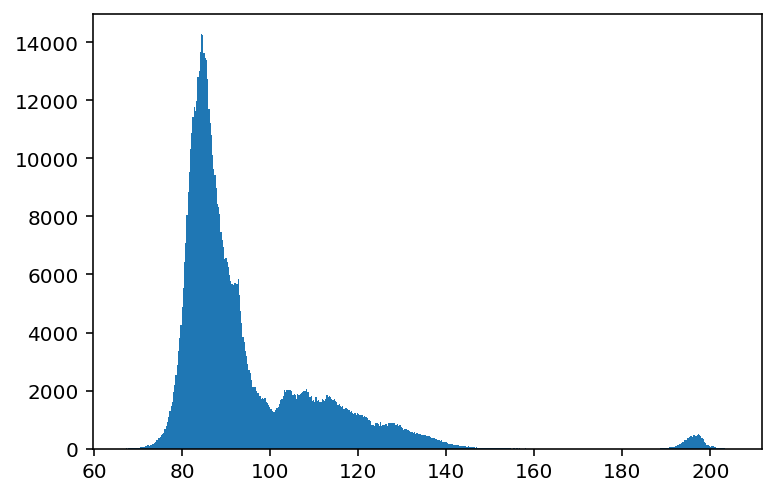

In [44]:
plt.hist(tt,bins=500)
plt.show()

In [45]:
tt = np.array(tt)

In [46]:
for d in trainlist:
    d.y = (d.y-tmean)/tsd
for d in vallist:
    d.y = (d.y-tmean)/tsd

In [47]:
tt2 = []
for d in trainlist:
    tt2.append(d.y)
for d in vallist:
    tt2.append(d.y)

In [48]:
tt2 = np.array(tt2)

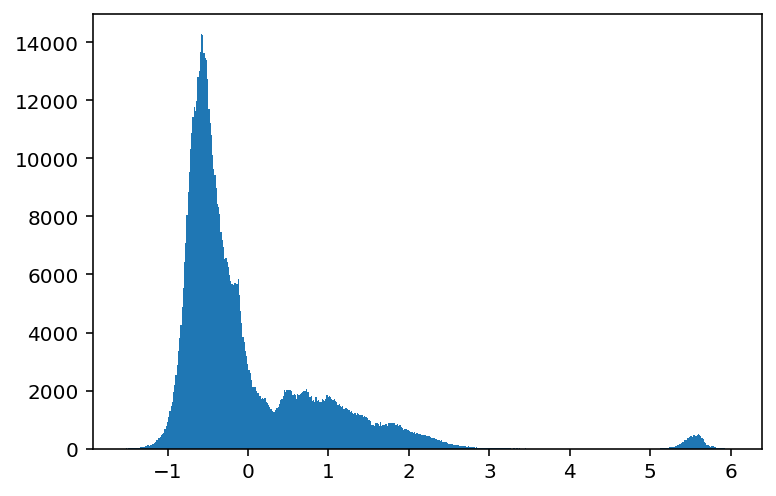

In [49]:
plt.hist(tt2,bins=500)
plt.show()

In [50]:
val_loader = DataLoader(vallist, batch_size=256,shuffle=False)
train_loader = DataLoader(trainlist, batch_size=256,shuffle=True)

In [51]:
#import gc
#del train_loader,val_loader,model
#gc.collect()
#torch.cuda.empty_cache()

In [52]:
ndim =128
edim = 64

In [53]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.lin0 = torch.nn.Linear(179, ndim)
        self.bn0 = BatchNorm1d(ndim)
        self.d0 = Dropout(0.1)
        
        nn = Sequential(Linear(18, edim), ReLU(), Linear(edim,2*edim), ReLU(),Linear(2*edim, ndim * ndim))
        self.conv = NNConv(ndim, ndim, nn, aggr='max', root_weight=True)
        self.gru = GRU(ndim, ndim)
        
        self.set2set = Set2Set(ndim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2*ndim, 192)
        self.lin2 = torch.nn.Linear(192,160)
        self.lin3 = torch.nn.Linear(160, ndim)
        self.lin4 = torch.nn.Linear(ndim, 1)

    def forward(self, data):
        out = F.selu(self.lin0(data.x))
        out = self.bn0(out)
        out = self.d0(out)
        h = out.unsqueeze(0)
        
        for i in range(3):
            m = F.selu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)
        
        out = self.set2set(out, data.batch)
        out = F.selu(self.lin1(out))
        out = F.selu(self.lin2(out))
        out = F.selu(self.lin3(out))
        out = self.lin4(out)
        
        return out.view(-1)

In [54]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# #model = torch.load('MPNN_64DIM_MODEL.pth')
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.00001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [55]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [56]:
xd = torch.load('Temp/t1.pth')
model = xd['bestmodel']
lrr = xd['lr']
ep = 301-xd['epoch']
print(xd['val_error'])

0.2955807857491468


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = RAdam(model.parameters(), lr=0.001,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [58]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# #model = torch.load('MPNN_64DIM_MODEL.pth')
# optimizer = RAdam(model.parameters(), lr=0.001,weight_decay=0.00001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [59]:
torch.cuda.empty_cache()

In [60]:
def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        #loss = torch.log(F.l1_loss(model(data),data.y)+ 4e-9)
        loss = F.l1_loss(model(data),data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()
    error = 0
    for data in loader:
        data = data.to(device)
        error += (model(data) * tsd - data.y * tsd).abs().sum().item()  # MAE
    return error / len(loader.dataset)

In [61]:
optimizer = RAdam(model.parameters(), lr=lrr,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [ ]:
best_val_error = None
bestmodel = None
for epoch in range(1, ep):
    start = time.time()
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)
    val_error = test(val_loader)
    scheduler.step(val_error)
    if best_val_error is None or val_error <= best_val_error:
        best_val_error = val_error
        bestmodel = deepcopy(model)
    if epoch%5 == 0:
        torch.save({'bestmodel':bestmodel,
                    'lr':lr,
                   'epoch':epoch,
                   'val_error':val_error},'Temp/t1.pth')
    end = time.time()
    print('Epoch: {:04d}, LR: {:9f},T Loss: {:.7f}, V MAE: {:.7f}, Time: {:.7f}'.format(epoch, lr, loss, val_error,end-start))

Epoch: 0001, LR:  0.000614,T Loss: 0.0086569, V MAE: 0.2904893, Time: 381.3529985
Epoch: 0002, LR:  0.000614,T Loss: 0.0094393, V MAE: 0.2936273, Time: 380.1291654
Epoch: 0003, LR:  0.000614,T Loss: 0.0097619, V MAE: 0.2885325, Time: 379.6791372
Epoch: 0004, LR:  0.000614,T Loss: 0.0097744, V MAE: 0.2862777, Time: 380.8357143


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0005, LR:  0.000614,T Loss: 0.0097412, V MAE: 0.2891924, Time: 381.1892405
Epoch: 0006, LR:  0.000614,T Loss: 0.0097166, V MAE: 0.2855580, Time: 381.4744670
Epoch: 0007, LR:  0.000614,T Loss: 0.0096769, V MAE: 0.2866718, Time: 382.9541562
Epoch: 0008, LR:  0.000614,T Loss: 0.0096788, V MAE: 0.2923432, Time: 379.6352170
Epoch: 0009, LR:  0.000614,T Loss: 0.0096201, V MAE: 0.2869647, Time: 380.1005368
Epoch: 0010, LR:  0.000614,T Loss: 0.0095753, V MAE: 0.2890374, Time: 388.1671107
Epoch: 0011, LR:  0.000614,T Loss: 0.0095754, V MAE: 0.2814566, Time: 392.5101702
Epoch: 0012, LR:  0.000614,T Loss: 0.0095390, V MAE: 0.2834146, Time: 393.1446772
Epoch: 0013, LR:  0.000614,T Loss: 0.0095414, V MAE: 0.2867199, Time: 398.1879888
Epoch: 0014, LR:  0.000614,T Loss: 0.0095287, V MAE: 0.2877516, Time: 398.5375469
Epoch: 0015, LR:  0.000614,T Loss: 0.0094222, V MAE: 0.2845605, Time: 397.8354461
Epoch: 0016, LR:  0.000614,T Loss: 0.0094604, V MAE: 0.2841111, Time: 397.1331229
Epoch: 0017, LR:

In [ ]:
#del train_loader,val_loader,model
#gc.collect()
#torch.cuda.empty_cache()

In [ ]:
torch.save(bestmodel,'MPNN_1JHC_SC2T_NFR.pth')#OG SELU AND CONNECTED TO TARGETS

In [ ]:
print('Best Validation MAE: {}'.format(best_val_error))
print('Best Log Validation MAE: {}'.format(np.log(best_val_error)))

In [ ]:
print(tmean,tsd)